In [181]:
%matplotlib inline
import matplotlib.pyplot as pl
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm

# A few useful constants
KEPLER_BEGIN_BK, KEPLER_END_BK = 130, 1582

In [185]:
transits = pd.read_hdf('observed-long-period-transits.h5', key='transits')
transits = transits[transits.tce_max_mult_ev < 20]
transits.head()

,kepid_x,tce,tce_max_mult_ev,tce_period,tce_plnt_num,transit_time_x,quarter,season,channel,idx,kepid_y,module,output,skygroup,transit_time_y
0,2304168,002304168-02,12.22,431.719,2,219.298,2,0,4,0,2304168,2,4,84,219.298
1,2304168,002304168-02,12.22,431.719,2,651.017,7,1,56,1,2304168,16,4,84,651.017
2,2304168,002304168-02,12.22,431.719,2,1082.736,11,1,56,2,2304168,16,4,84,1082.736
3,2304168,002304168-02,12.22,431.719,2,1514.455,16,2,84,3,2304168,24,4,84,1514.455
4,2303102,002303102-10,11.51,480.481,10,161.570,1,3,32,4,2303102,10,4,84,161.570


14it [00:25,  1.99s/it]


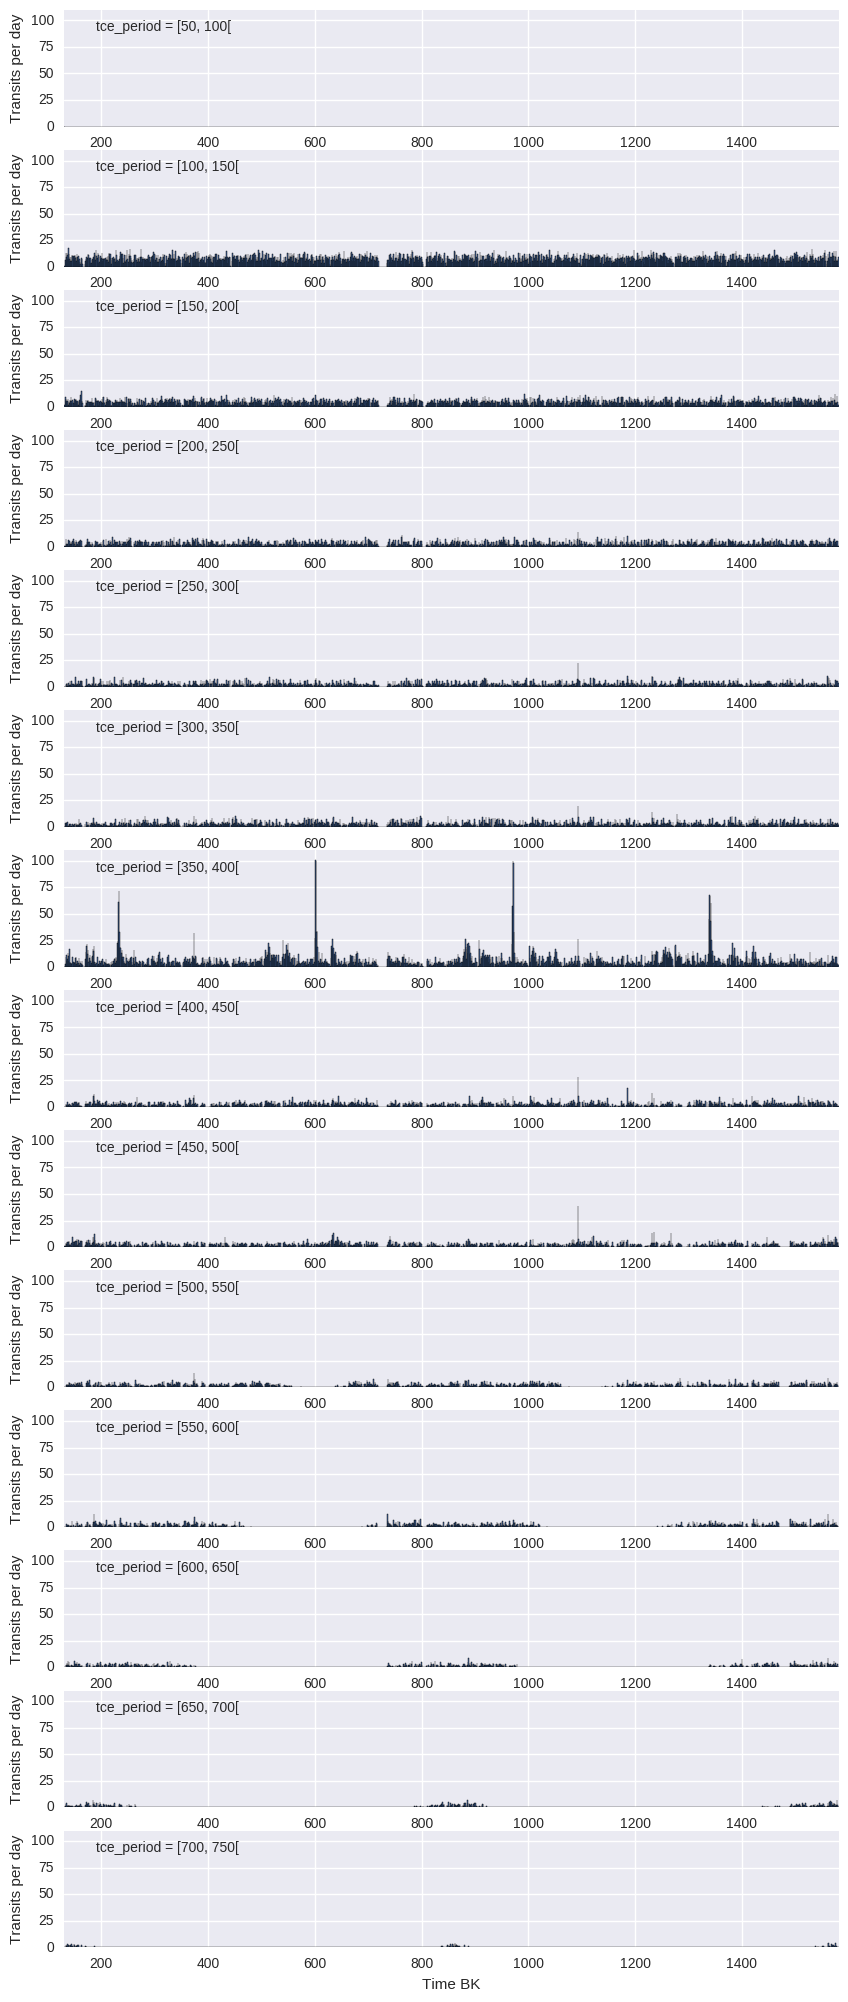

In [186]:
stepsize = 50
boundaries = range(50, 750, stepsize)
pl.figure(figsize=(10, 25))
for idx, bound in tqdm(enumerate(boundaries)):
    mask = (transits.tce_period >= bound) & (transits.tce_period < bound + stepsize)
    pl.subplot(len(boundaries), 1, idx+1)
    _ = pl.hist(transits.transit_time_x[mask],
                range=(KEPLER_BEGIN_BK, KEPLER_END_BK),
                bins=(KEPLER_END_BK - KEPLER_BEGIN_BK))  # 1 bin per day
    pl.xlim([KEPLER_BEGIN_BK, KEPLER_END_BK])
    pl.ylim([0, 110])
    pl.yticks(range(0, 101, 25))
    pl.text(190, 90, 'tce_period = [{}, {}['.format(bound, bound+stepsize))
    pl.ylabel('Transits per day')
pl.xlabel('Time BK')

In [188]:
n_transits_per_quarter = transits.groupby('quarter').size()

In [189]:
KEPLER_QUARTERS = pd.read_csv('../data/kepler-quarters.csv')[1:]
days_per_quarter = KEPLER_QUARTERS.last_lc_mjd - KEPLER_QUARTERS.first_lc_mjd

<Container object of 17 artists>

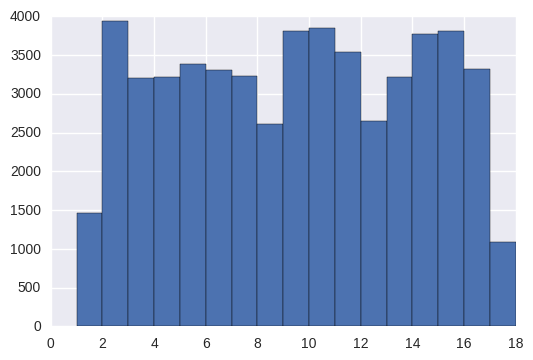

In [190]:
pl.bar(n_transits_per_quarter.index, n_transits_per_quarter, 1)

<Container object of 17 artists>

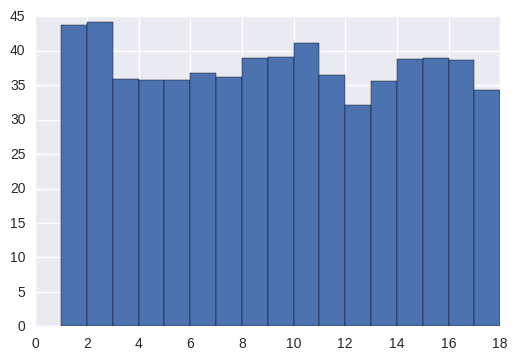

In [191]:
pl.bar(n_transits_per_quarter.index, n_transits_per_quarter / days_per_quarter, 1)


## Count the transits per skygroup and season

In [192]:
transits_per_skygroup_and_season = transits.groupby(['skygroup', 'season']).size()
transits_per_skygroup_and_season.head()

skygroup  season
1         0         92
          1         92
          2         80
          3         94
2         0         88
dtype: int64

In [193]:
unique_tces = transits.groupby(['skygroup', 'season']).tce.nunique()

In [195]:
# How long is each season?
seasons = [0, 1, 2, 3]
n_days = []
for season in seasons:
    quarters = transits.quarter[transits.season == season].unique()
    n_days.append( sum([days_per_quarter.ix[q] for q in quarters]) )
df_n_days = pd.DataFrame({'n_days': n_days}, index=seasons)
df_n_days.index.name = 'season'
df_n_days

,n_days
season,
0,369.398637
1,373.424100
2,325.282400
3,347.636795


In [196]:
df_n_transits = pd.DataFrame(transits_per_skygroup_and_season, columns=['n_transits'])
df_n_transits['n_tces'] = unique_tces
df_n_transits

n_transits  n_tces
skygroup season                    
1        0               92      54
         1               92      61
         2               80      53
         3               94      61
2        0               88      49
         1              135      67
         2              117      60
         3               80      48
3        0               46      33
         1               41      29
         2               48      34
         3               54      38
4        0              150      84
         1              124      71
         2              111      72
         3              134      80
5        0              121      58
         1              107      58
         2               16      16
         3               94      54
6        0               62      32
         1               74      34
         2               18      18
         3               43      26
7        0              146      69
         1              131      64
         2               17      17
         3              115      66
8        0               81      50
         1               89      49
...                     ...     ...
77       2              180     103
         3              175     101
78       0               52      52
         1              242     113
         2              178     102
         3              214     110
79       0               60      60
         1              283     136
         2              196     120
         3              247     131
80       0               76      76
         1              280     149
         2              232     139
         3              285     154
81       0              214     122
         1              221     122
         2              178     103
         3              209     116
82       0              207     113
         1              236     117
         2              194     110
         3              208     105
83       0              291     157
         1              299     158
         2              239     140
         3              263     146
84       0              197     113
         1              210     114
         2              167     104
         3              191     104

[336 rows x 2 columns]

In [197]:
df_merged = df_n_transits.merge(df_n_days, left_index=True, right_index=True)
df_merged['transits_per_day'] = df_merged.n_transits / df_merged.n_days
df_merged.head()

n_transits  n_tces      n_days  transits_per_day
skygroup season                                                  
1        0               92      54  369.398637          0.249053
         1               92      61  373.424100          0.246369
         2               80      53  325.282400          0.245940
         3               94      61  347.636795          0.270397
2        0               88      49  369.398637          0.238225

In [198]:
# Add the channel number
channel = []
for skygroup, season in df_merged.index:
    channel.append(transits[(transits.skygroup == skygroup) & (transits.season == season)].channel.iloc[0])
df_merged['channel'] = channels
df_merged

n_transits  n_tces      n_days  transits_per_day  channel
skygroup season                                                           
1        0               92      54  369.398637          0.249053       81
         1               92      61  373.424100          0.246369       29
         2               80      53  325.282400          0.245940        1
         3               94      61  347.636795          0.270397       53
2        0               88      49  369.398637          0.238225       82
         1              135      67  373.424100          0.361519       30
         2              117      60  325.282400          0.359687        2
         3               80      48  347.636795          0.230125       54
3        0               46      33  369.398637          0.124527       83
         1               41      29  373.424100          0.109795       31
         2               48      34  325.282400          0.147564        3
         3               54      38  347.636795          0.155335       55
4        0              150      84  369.398637          0.406065       84
         1              124      71  373.424100          0.332062       32
         2              111      72  325.282400          0.341242        4
         3              134      80  347.636795          0.385460       56
5        0              121      58  369.398637          0.327559       77
         1              107      58  373.424100          0.286537       49
         2               16      16  325.282400          0.049188        5
         3               94      54  347.636795          0.270397       33
6        0               62      32  369.398637          0.167840       78
         1               74      34  373.424100          0.198166       50
         2               18      18  325.282400          0.055337        6
         3               43      26  347.636795          0.123692       34
7        0              146      69  369.398637          0.395237       79
         1              131      64  373.424100          0.350808       51
         2               17      17  325.282400          0.052262        7
         3              115      66  347.636795          0.330805       35
8        0               81      50  369.398637          0.219275       80
         1               89      49  373.424100          0.238335       52
...                     ...     ...         ...               ...      ...
77       2              180     103  325.282400          0.553365       77
         3              175     101  347.636795          0.503399       49
78       0               52      52  369.398637          0.140769        6
         1              242     113  373.424100          0.648057       34
         2              178     102  325.282400          0.547217       78
         3              214     110  347.636795          0.615585       50
79       0               60      60  369.398637          0.162426        7
         1              283     136  373.424100          0.757851       35
         2              196     120  325.282400          0.602553       79
         3              247     131  347.636795          0.710512       51
80       0               76      76  369.398637          0.205740        8
         1              280     149  373.424100          0.749818       36
         2              232     139  325.282400          0.713226       80
         3              285     154  347.636795          0.819821       52
81       0              214     122  369.398637          0.579320        1
         1              221     122  373.424100          0.591820       53
         2              178     103  325.282400          0.547217       81
         3              209     116  347.636795          0.601202       29
82       0              207     113  369.398637          0.560370        2
         1              236     117  373.424100          0.631989       54
         2              194     110  325.2

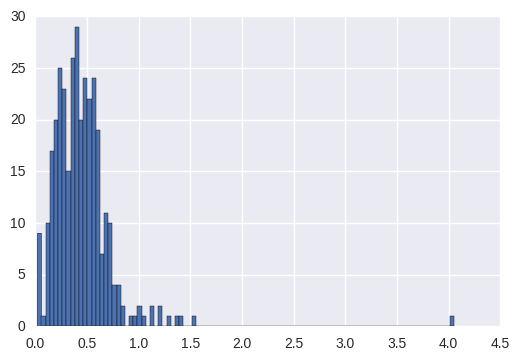

In [199]:
df_merged.transits_per_day.hist(bins=100)

In [200]:
outlier_treshold = df_merged.transits_per_day.median() + 1.5*df_merged.transits_per_day.std()
print(outlier_treshold)
df_merged[df_merged.transits_per_day > outlier_treshold]

0.8691646552205595


n_transits  n_tces      n_days  transits_per_day  channel
skygroup season                                                           
18       1              382     194  373.424100          1.022966       26
         3              449     218  347.636795          1.291578       58
26       0              414     174  369.398637          1.120740       58
41       1              527     214  373.424100          1.411264       44
42       0              500     211  369.398637          1.353551       44
43       3              533     214  347.636795          1.533209       44
58       0             1498     532  369.398637          4.055240       26
         2              374     211  325.282400          1.149770       58
66       1              457     230  373.424100          1.223810       58
         3              414     219  347.636795          1.190898       26
75       0              379     192  369.398637          1.025992       11
         1              352     182  373.424100          0.942628       15
         2              311     172  325.282400          0.956092       75
         3              362     177  347.636795          1.041317       71

In [201]:
df_merged.to_hdf('transit-rate-by-skygroup.h5', key='rate')